In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from pylab import rcParams
import re
import os
import time
from datetime import datetime

In [2]:
df = pd.read_csv("readings.csv")
display(df.head())

,cpu_speed,volts,fan_speed,cpu_pct,load_avg,temp
0,1.500013,0.7200,3019.0,5.1,0.577148,46.6
1,2.400024,0.8806,3020.0,23.3,0.577148,46.6
2,2.400020,0.8806,3021.0,1.9,0.577148,47.2
3,2.400020,0.8806,3020.0,1.9,0.577148,47.2
4,2.400030,0.8806,3021.0,1.0,0.577148,46.6


In [3]:
# Strengthen our correlation by applying a rolling average to certain columns.
df_adjusted = df.copy()
rolling_cols = ['cpu_speed', 'volts', 'fan_speed', 'cpu_pct']
df_adjusted[rolling_cols] = df_adjusted[rolling_cols].rolling(window=5).mean()

display(df_adjusted.info())
display(df_adjusted.corr())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   cpu_speed  2496 non-null   float64
 1   volts      2496 non-null   float64
 2   fan_speed  2496 non-null   float64
 3   cpu_pct    2496 non-null   float64
 4   load_avg   2500 non-null   float64
 5   temp       2500 non-null   float64
dtypes: float64(6)
memory usage: 117.3 KB


None

,cpu_speed,volts,fan_speed,cpu_pct,load_avg,temp
cpu_speed,1.000000,0.266795,0.727922,0.650388,0.614881,0.824529
volts,0.266795,1.000000,0.073997,0.178357,0.201503,0.205284
fan_speed,0.727922,0.073997,1.000000,0.506010,0.655393,0.645568
cpu_pct,0.650388,0.178357,0.506010,1.000000,0.644502,0.836964
load_avg,0.614881,0.201503,0.655393,0.644502,1.000000,0.766714
temp,0.824529,0.205284,0.645568,0.836964,0.766714,1.000000


In [5]:
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Grab the adjusted data, but drop any rows with missing data.
# The rows with missing data were created by the rolling average.
df_data = df_adjusted.dropna(how="any")

# Try it first with one column, then with more than one. Comment out
# the one you don't want to use and uncomment the one you do.
# We know from the histograms that volts is probably useless as a predictor!
# feature_cols = ["load_avg"]
feature_cols = ["cpu_pct", "load_avg", "cpu_speed", "fan_speed"]

# Separate the feature data from the target data we want to predict.
X = df_data[feature_cols]
y = df_data.temp

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
display(f"Train length: {len(X_train)}, Test length: {len(X_test)}")

'Train length: 1996, Test length: 500'

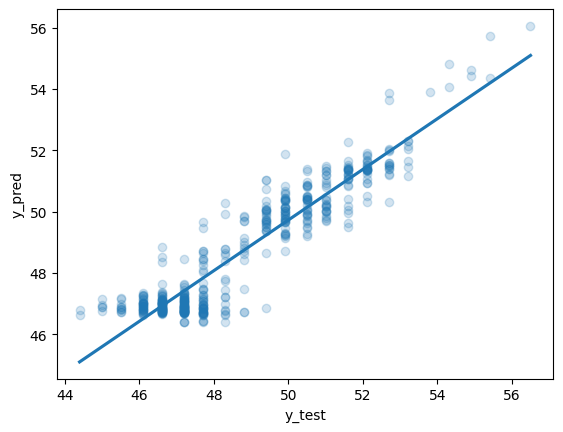

'Mean squared error: 0.66'

'Coefficient of determination: 0.87'

In [6]:
import seaborn as sns
plt.clf()

linreg = make_pipeline(StandardScaler(), 
                        LinearRegression()) 
linreg.fit(X_train,y_train)
y_pred = linreg.predict(X_test)

sns.regplot(x=y_test, y=y_pred, ci=None, scatter_kws={'alpha':0.2})
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

display(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
display(f"Coefficient of determination: {r2_score(y_test, y_pred):.2f}")

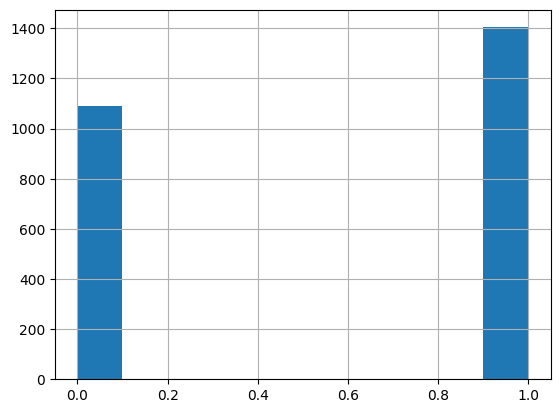

,cpu_speed,volts,fan_speed,cpu_pct,load_avg,temp,fan_state
cpu_speed,1.000000,0.266795,0.727922,0.650388,0.614881,0.824529,0.728694
volts,0.266795,1.000000,0.073997,0.178357,0.201503,0.205284,0.067758
fan_speed,0.727922,0.073997,1.000000,0.506010,0.655393,0.645568,0.991132
cpu_pct,0.650388,0.178357,0.506010,1.000000,0.644502,0.836964,0.509066
load_avg,0.614881,0.201503,0.655393,0.644502,1.000000,0.766699,0.638073
temp,0.824529,0.205284,0.645568,0.836964,0.766699,1.000000,0.642958
fan_state,0.728694,0.067758,0.991132,0.509066,0.638073,0.642958,1.000000


'Train length: 1996, Test length: 500'

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

df_data = df_adjusted.copy().dropna(how="any")

# Change fan speed into an on/off indicator.
df_data["fan_state"] = df_data.fan_speed.apply(lambda x: 1 if x > 0 else 0)
plt.clf()
df_data.fan_state.hist()
plt.show()

display(df_data.corr())

# feature_cols = ["volts", "cpu_pct", "load_avg", "cpu_speed", "temp"] # NOT fan speed!
feature_cols = ["load_avg", "cpu_speed"] # NOT fan speed!

X = df_data[feature_cols].values
y = df_data.fan_state.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
display(f"Train length: {len(X_train)}, Test length: {len(X_test)}")


In [8]:
logreg = make_pipeline(StandardScaler(), 
                       LogisticRegression()) 
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(metrics.classification_report(y_test, y_pred))
display(metrics.confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       229
           1       0.93      0.87      0.90       271

    accuracy                           0.89       500
   macro avg       0.89      0.89      0.89       500
weighted avg       0.89      0.89      0.89       500



array([[210,  19],
       [ 35, 236]])

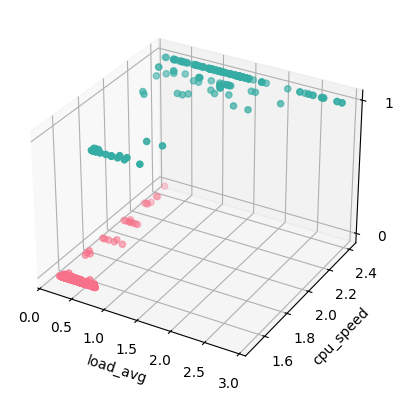

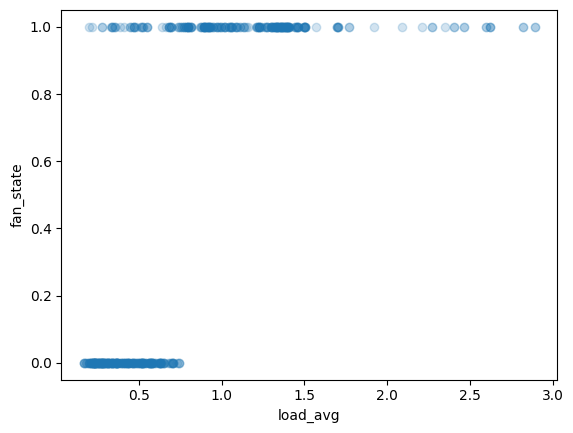

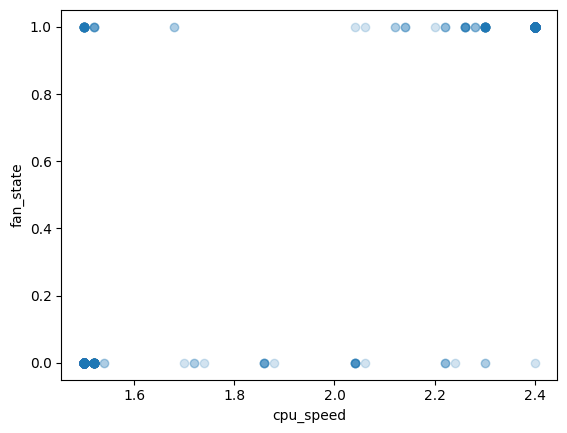

In [9]:
from matplotlib.colors import ListedColormap

plt.clf()

ax = plt.axes(projection = '3d')

x = np.array(X_test).T[0]
y = np.array(X_test).T[1]
z = y_pred

ax.set_xlabel("load_avg")
ax.set_ylabel("cpu_speed")
ax.set_zlabel("fan_state")
ax.set_zticks([0,1])

cmap = ListedColormap(sns.color_palette("husl", 2).as_hex())
ax.scatter(x, y, z, c=z, cmap=cmap)

plt.show()

plt.clf()
ax = plt.axes()
ax.scatter(np.array(X_test).T[0], y_pred, alpha=0.2)
plt.xlabel('load_avg')
plt.ylabel('fan_state')
plt.show()

plt.clf()
ax = plt.axes()
ax.scatter(np.array(X_test).T[1], y_pred, alpha=0.2)
plt.xlabel('cpu_speed')
plt.ylabel('fan_state')
plt.show()


# Tensorflow: Multiple variable linear regression

In [6]:
import tensorflow as tf

def plot_preds(x, y, model, title):
  plt.figure()
  plt.plot(x, y, '.', label='Data')
  plt.plot(x, model(x), label='Predictions')
  plt.title(title)
  plt.legend()

df_data = df_adjusted.dropna(how="any")

feature_cols = ["cpu_pct", "load_avg", "cpu_speed", "fan_speed"]

# Separate the feature data from the target data we want to predict.
X = df_data[feature_cols]
y = df_data.temp

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
display(f"Train length: {len(X_train)}, Test length: {len(X_test)}")

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))
print(normalizer.mean.numpy())
first = np.array(X_train[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())
    
linear_model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(units=1)
])

linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error',
    metrics=[tf.keras.metrics.R2Score()]
)

history = linear_model.fit(
    X_train,
    y_train,
    epochs=20,
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

linear_model.evaluate(X_test, y_test, verbose=1)


'Train length: 1996, Test length: 500'

[[1.0847786e+01 8.0221796e-01 1.9221560e+00 1.6904337e+03]]
First example: [[  12.38    1.34    2.28 3042.8 ]]

Normalized: [[0.1  0.98 0.83 0.91]]
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6843 - r2_score: 0.8448 


[0.6505759954452515, 0.870459794998169]